# XPN 2020

After taking a year off from playlists, they are back.
This time instead of an A-Z walk though their catalog
[WXPN](https://www.xpn.org) is back to listener curated lists
with this years [2002 Countdown](https://xpn.org/music-artist/885-countdown/2020/).
This time the station is doing their own stats page,
[2020 Countdown, by the Numbers](https://thekey.xpn.org/wxpn-2020-numbers/).
But for fun, I'll still do something.

In [1]:
%matplotlib inline
from IPython.display import display, HTML

## Status

It's Monday and we are more than half done.
[WXPN](https://xpn.org) had done a great job of doing their own stats.
Checkout the thier stuff at [XPN 2020, by the numbers](https://thekey.xpn.org/wxpn-2020-numbers/).
I'll keep re-running this to kep the data up.
But I'm going to try to find some interesting insights to drill down on to add value,
since the station has the basics like "which artists are playing the most" covered.

* Add comparision with 2014's 885 best and 88 worst
* Make joins to best and worst case insensitive, so ABBA matches Abba.  Thanks to [Joe Lynch](https://twitter.com/jwlynchjr) for catching that.
* Found another matchup issue with the comparision, working on that. May have something interesting as that gets fixed and we move into the top half of the countdown.
* Fixed encoding issue with non-ascii characters, or more correctly backed out a fix from a few years base that's no longer needed.
* Truncate the growing set of overlaps with the 885 best.  That will keep growing fast now.



## Loading the Data

Most people are probably not too interested in how I pull the data, clean it and augment it.
If you do the details are in my [Data Loading notebook](DataLoading.ipynb).
If you want a copy of the raw data to play with yourself, 
feel free to look at [xpn2020.csv](./data/xpn2020.csv).
If you do something interesting with the data,
please let me know.
And tell the station and post to [twitter](https://twitter.com) with the hash tag `#XPN2020`.
I'm sure other listeners will be glad to see what you have done.

In [2]:
import pandas as pd
from datetime import date, datetime, time, timedelta
from os import path
data_dir = './data'
playlist_file = path.join(data_dir, 'xpn2020.csv')
playlist = pd.read_csv(playlist_file)

playlist['Air Time'] = pd.to_datetime(playlist['Air Time'], errors='coerce')
last_play = playlist.loc[playlist['Air Time'].idxmax()]
end_time = last_play['Air Time'] + timedelta(seconds = 60 * last_play['Duration'])
HTML('<p>So far, as of %s, we have seen %d tracks with %d unique titles, from %d artists.</p>' %\
    (end_time.strftime('%b %d %I:%M%p'),
     len(playlist),
     playlist.describe(include='all')['Title']['unique'], 
     playlist.describe(include='all')['Artist']['unique']
     ))

## Data Analysis

### Most Popular Artists

It's always interesting to see which artists show up the most.
There tends to be bias to nostalgia.
But there's usually some new stuff mixed in.

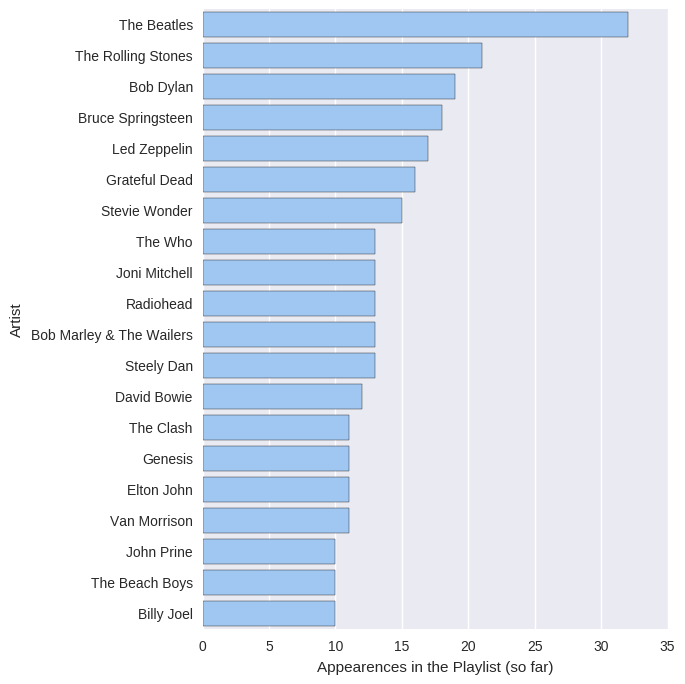

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
c = playlist['Artist'].value_counts()
artists = pd.DataFrame(zip(c.keys().tolist(), c.tolist()),
                       columns=('Artist', 'Count'))
f, ax = plt.subplots(figsize=(6, 8))
sns.set_color_codes('pastel')
sns.barplot(y='Artist', x='Count', data=artists[artists['Count'] > 9], color='b')
ax.set(xlabel="Appearences in the Playlist (so far)")

### Songs by Year

[XPN](https://xpn.org) plays a lot of new music.
I count on them to introduce me to what the cool kids are listening to.
Frankly it's silly to go through life only listening to what you listed to in highschool.
Nostalgia, being what it is, the countdowns tend to skew old.

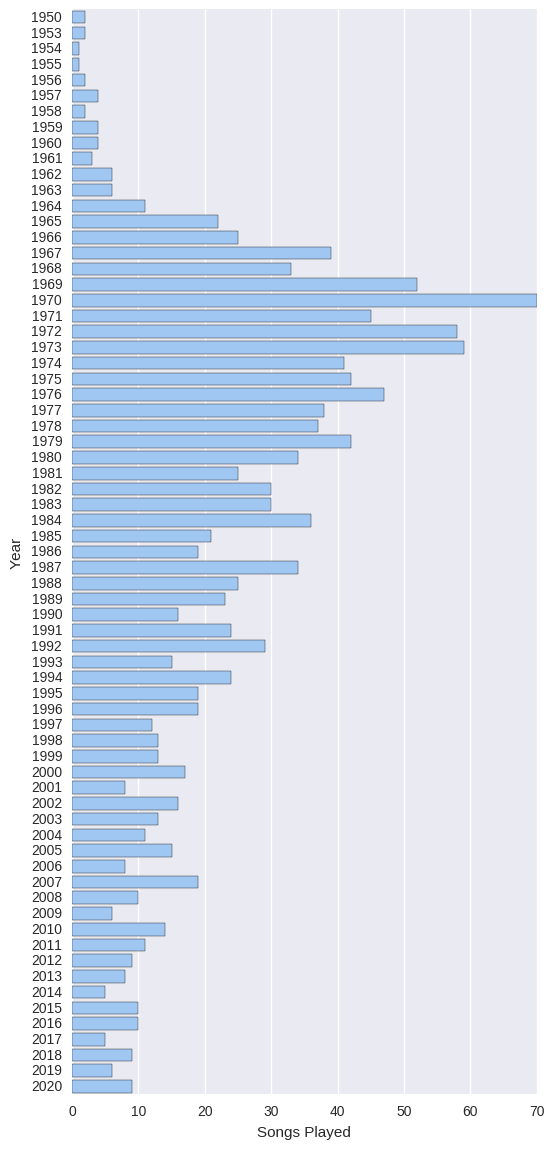

In [4]:
f, ax = plt.subplots(figsize=(6, 14))
sns.set_color_codes('pastel')
sns.countplot(y='Year', data=playlist[playlist['Year'] > 0], color='b')
ax.set(xlabel="Songs Played", ylabel="Year")

### Artists Who Have Played For The Most Time

This isn't overly accurate, as it is based on the successive start times
in the playlist, and those only have one minute granularity.
Plus the hosts do pause to talk every few songs,
and that isn't factored out.
But it's the best we have.
Besides someone asked about this.
Playing more songs helps with total duration,
but so does long songs.

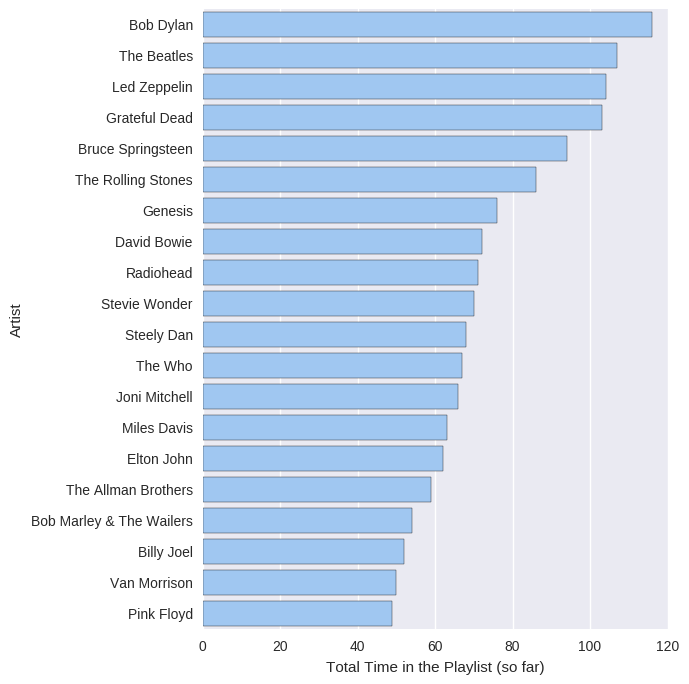

In [5]:
artist_durations = playlist.groupby('Artist')['Duration'].sum().to_frame()
artist_durations = artist_durations.reset_index()
artist_durations = artist_durations.sort_values(by='Duration', ascending=False)

f, ax = plt.subplots(figsize=(6, 8))
sns.set_color_codes('pastel')
sns.barplot(y='Artist', x='Duration', data=artist_durations.head(20), color='b')
ax.set(xlabel="Total Time in the Playlist (so far)")

### Longest Songs

We can look at which songs took the longest.
During the playlist, sometimes missing data creates artificial "long tracks."
Generally these get corrected, so what's here now seems legit.


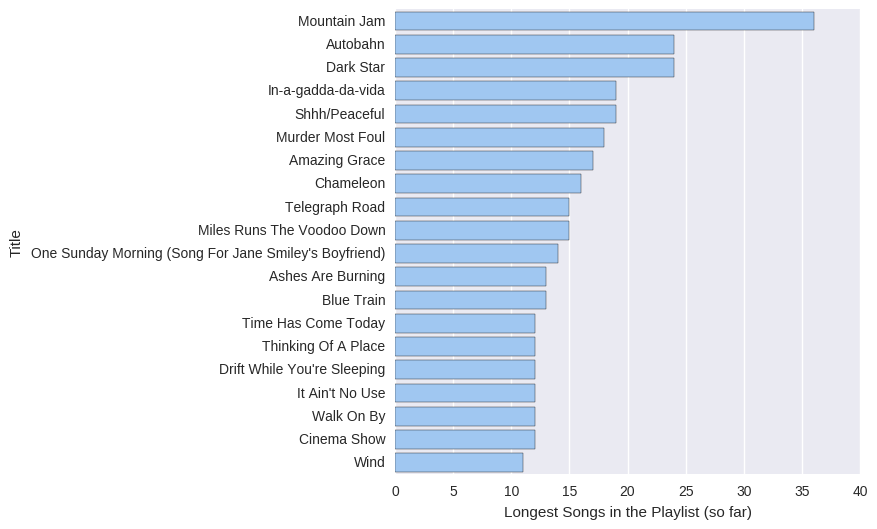

In [6]:
long_songs = playlist.sort_values(by='Duration', ascending=False)
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes('pastel')
sns.barplot(y='Title', x='Duration', data=long_songs.head(20), color='b')
ax.set(xlabel="Longest Songs in the Playlist (so far)")

### Comparision with other XPN Playlists

#### 885 Best and 88 Worst

Back in 2014 there was a very similar [885 All Time Greatest Song](https://xpn.org/music-artist/885-countdown/2014/885-countdown-2014) countdown.
While this countdown has almost 3 times as many songs,
it might be interesting to see how they compare.

In [7]:

def overlapping_songs(list1, list2):
    import string
    list1a = list1.copy()
    list2a = list2.copy()
    list1a['Title_lc'] = list1a['Title'].str.lower().str.translate(None, string.punctuation).str.translate(None, string.whitespace)
    list1a['Artist_lc'] = list1a['Artist'].str.lower().str.translate(None, string.punctuation).str.translate(None, string.whitespace)
    list2a['Title_lc'] = list2a['Title'].str.lower().str.translate(None, string.punctuation).str.translate(None, string.whitespace)
    list2a['Artist_lc'] = list2a['Artist'].str.lower().str.translate(None, string.punctuation).str.translate(None, string.whitespace)
    intersect = pd.merge(list1a, list2a, how='inner', on=['Title_lc', 'Artist_lc'])
    intersect.drop(intersect.columns.difference(['Title_x','Artist_x']), 1, inplace=True)
    intersect.columns = ['Artist', 'Title']
    return intersect

    
best885_file = path.join(data_dir, '885best.csv')
best885 = pd.read_csv(best885_file)
besties = overlapping_songs(playlist, best885)
besties.to_csv(path.join(data_dir, 'XPN2020_and_885Best.csv'), index=False)


worst88_file = path.join(data_dir, '88worst.csv')
worst88 = pd.read_csv(worst88_file)
horrors = overlapping_songs(playlist, worst88)
horrors.to_csv(path.join(data_dir, 'XPN2020_and_88Worst.csv'), index=False)

s= "<p>Of the %d tracks in the 2020 Countdown so far, " + \
    "%d or %0.2f%% where in 2014's 885 best playlist. " + \
    "Those are available as <a href='data/XPN2020_and_885Best.csv'>XPN2020_and_885Best.csv</a>. " + \
    "Sadly %d were in 2014's 88 worst playlist. " + \
    "Those are available as <a href='data/XPN2020_and_88Worst.csv'>XPN2020_and_88Worst.csv</a>.</p>"
HTML(s %(len(playlist), len(besties), float(len(besties) * 100) / float(len(playlist)),
         len(horrors)))

Now that we're into the top half of the playlist
the overlap is getting big.
So here's a sample, but if you want them all get the csv file
[XPN2020_and_88Worst.csv](data/XPN2020_and_88Worst.csv).

In [8]:
HTML(besties.head(15).to_html(index=False))

Artist,Title
Grand Funk Railroad,I'm Your Captain
Prince,1999
Carole King,You've Got A Friend
Iron Butterfly,In-a-gadda-da-vida
Santana,Smooth
The Rolling Stones,Shattered
Elvis Costello,Man Out Of Time
Vampire Weekend,A-Punk
The Beatles,Got To Get You Into My Life
M83,Midnight City


And what were those worst songs that were apparently someone's favorites?
Fortunatly, that's small enough to show the whole list.

In [9]:
HTML(horrors.to_html(index=False, columns=['Title', 'Artist']))

Title,Artist
Born In The USA,Bruce Springsteen
Afternoon Delight,Starland Vocal Band
Dancing Queen,Abba
We Didn't Start The Fire,Billy Joel
MacArthur Park,Richard Harris


#### How the Rankings Changed

If life were consistant you might expect the top 885 songs
to match the 885 Best list from 2014.
Of course this isn't true.
New songs come out, tastes change,
and a lot depends on who bothers to vote.
So how did it change?


In [10]:
def left_join(list1, list2, suffixes):
    import string
    list1a = list1.copy()
    list2a = list2.copy()
    list1a['Title_lc'] = list1a['Title'].str.lower().str.translate(None, string.punctuation).str.translate(None, string.whitespace)
    list1a['Artist_lc'] = list1a['Artist'].str.lower().str.translate(None, string.punctuation).str.translate(None, string.whitespace)
    list2a['Title_lc'] = list2a['Title'].str.lower().str.translate(None, string.punctuation).str.translate(None, string.whitespace)
    list2a['Artist_lc'] = list2a['Artist'].str.lower().str.translate(None, string.punctuation).str.translate(None, string.whitespace)
    list2a.drop(['Title', 'Artist'], 1, inplace=True) 
    intersect = pd.merge(list1a, list2a, how='left', on=['Title_lc', 'Artist_lc'], suffixes=suffixes)
    intersect.drop(['Title_lc', 'Artist_lc'], 1, inplace=True)
    return intersect
    


best885.insert(0, 'Rank', range(1, 1 + len(best885)))
xpn2020 = playlist.copy()
xpn2020.drop(xpn2020.columns.difference(['Title', 'Artist']), 1, inplace=True)
xpn2020.insert(0, 'Rank', range(2020, 2020 - len(xpn2020), -1))
best885_reranked = left_join(best885, xpn2020, ['_885best', '_xpn2020'])
best885_reranked['Change'] = best885_reranked['Rank_885best'] - best885_reranked['Rank_xpn2020']

In [11]:
s = """
    Of the %d tracks in the 885 best, %d have not yet been played in XPN 2020.
    Of the %d that have been played, %d have lower rankings that before,
    %d have higher rankings than before, and %d are unchanged."""

reranked = best885_reranked[best885_reranked['Rank_xpn2020'].notnull()].copy()
reranked[['Rank_xpn2020']] = reranked[['Rank_xpn2020']].astype(int)
reranked[['Change']] = reranked[['Change']].astype(int)
reranked.to_csv(path.join(data_dir, '885best_xpn2020_reranked.csv'),
                index=False, encoding='utf-8',
                columns=['Title', 'Artist', 'Rank_885best', 'Rank_xpn2020', 'Change'])


HTML(s %(len(best885_reranked), 
         len(best885_reranked[pd.isnull(best885_reranked['Rank_xpn2020'])]),
         len(best885_reranked[pd.notnull(best885_reranked['Rank_xpn2020'])]),
         len(best885_reranked[best885_reranked['Change'] < 0]),
         len(best885_reranked[best885_reranked['Change'] > 0]),
         len(best885_reranked[best885_reranked['Change'] == 0])))

The overlapped tracks are availiable as [885best_xpn2020_reranked.csv](data/885best_xpn2020_reranked.csv) and and shown below.

##### Tracks Ranked the same or higher in 2020

In [12]:
HTML(best885_reranked[best885_reranked['Change'] > 0].to_html(index=False, 
    columns=['Title', 'Artist', 'Rank_885best', 'Rank_xpn2020', 'Change']))

Title,Artist,Rank_885best,Rank_xpn2020,Change
Isn't It A Pity,George Harrison,692,678,14
Pale Blue Eyes,The Velvet Underground,730,649,81
Werewolves Of London,Warren Zevon,731,700,31
Don't Let The Sun Go Down On Me,Elton John,785,784,1
Rain,The Beatles,827,683,144
Ceremony,New Order,848,693,155
Midnight In Harlem,Tedeschi Trucks Band,852,673,179
Proud Mary,Creedence Clearwater Revival,862,858,4
Windows Are Rolled Down,Amos Lee,863,667,196
Song For Sharon,Joni Mitchell,870,786,84


##### Tracks Ranked lower but still ing the top 885

In [13]:
HTML(best885_reranked[(best885_reranked['Change'] < 0) & (best885_reranked['Rank_xpn2020'] < 886)].to_html(index=False, 
    columns=['Title', 'Artist', 'Rank_885best', 'Rank_xpn2020', 'Change']))

Title,Artist,Rank_885best,Rank_xpn2020,Change
Do You Realize,The Flaming Lips,136,724,-588
Diamonds And Rust,Joan Baez,176,725,-549
So What,Miles Davis,178,692,-514
Diamonds On The Soles Of Her Shoes,Paul Simon,199,682,-483
Wonderwall,Oasis,209,802,-593
Since I've Been Loving You,Led Zeppelin,211,681,-470
Heavenly Day,Patty Griffin,212,709,-497
Let Down,Radiohead,227,721,-494
Fool In The Rain,Led Zeppelin,243,730,-487
Let's Get It On,Marvin Gaye,252,745,-493


##### Tracks from the 885 best that ranked below 885

In [14]:
HTML(best885_reranked[best885_reranked['Rank_xpn2020'] > 885].to_html(index=False, 
    columns=['Title', 'Artist', 'Rank_885best', 'Rank_xpn2020', 'Change']))

Title,Artist,Rank_885best,Rank_xpn2020,Change
Black,Pearl Jam,85,1614,-1529
Take Me To Church,Hozier,102,908,-806
Billie Jean,Michael Jackson,111,1488,-1377
Wordless Chorus,My Morning Jacket,157,1767,-1610
Cinnamon Girl,Neil Young,203,951,-748
Born To Be Wild,Steppenwolf,248,1754,-1506
Sweet Thing,Van Morrison,287,985,-698
Carry On,Crosby Stills Nash & Young,298,1239,-941
Tangerine,Led Zeppelin,305,1066,-761
Dondante,My Morning Jacket,313,1259,-946
